# import

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import math
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from  PIL import Image
import os
import random
from tqdm import tqdm
import timm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 定义参数

In [2]:
INPUT_PATH = '../input/mymodelparam'
TRAIN_CSV_PATH = '../input/cassava-leaf-disease-classification/train.csv'
TRAIN_IMAGE_PATH = '../input/cassava-leaf-disease-classification/train_images/'
TEST_IMAGE_PATH = '../input/cassava-leaf-disease-classification/test_images/'
SUBMISSION_PATH = 'submission.csv'
DEVICES = [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]
OUT_FEATURES = 5
NUM_EPOCHS = 17
BATCH_SIZE = 32
IMAGE_SIZE = 512
OPTIMIZER = torch.optim.AdamW
SEED = 42
LR_START = 1e-5
LR_MAX = 2e-4
LR_FINAL = 1e-5
TTA = 3

# tr1.损失函数
1st solution's loss
1. B4: Sigmoid Focal Cross Entropy Loss: is good for class imbalance problems / label smoothing
2. ResNeXt50: Cross Entropy Loss

In [3]:
def sigmoid_focal_cross_entropy(y_hat, y_true, alpha=0.25, gamma=2.0):
    # label smoothing
    def smooth(y, smooth_factor):
        assert  len(y.shape) == 2
        y *= 1 - smooth_factor
        y += smooth_factor / y.shape[1]
        return y

    smooth_factor = 0.1

    if not isinstance(y_true, torch.Tensor):
        y_true = torch.tensor(y_true)
    if not isinstance(y_hat, torch.Tensor):
        y_hat = torch.tensor(y_hat)

    y_true = smooth(y_true, smooth_factor)

    cross_entropy = F.binary_cross_entropy_with_logits(y_hat, y_true, reduction='none')
    p_t = y_true * y_hat + (1 - y_true) * (1 - y_hat)
    alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
    modulating_factor = (1.0 - p_t).pow(gamma)

    return torch.sum(alpha_t * modulating_factor * cross_entropy, dim=-1)

# tr2.learning_rate

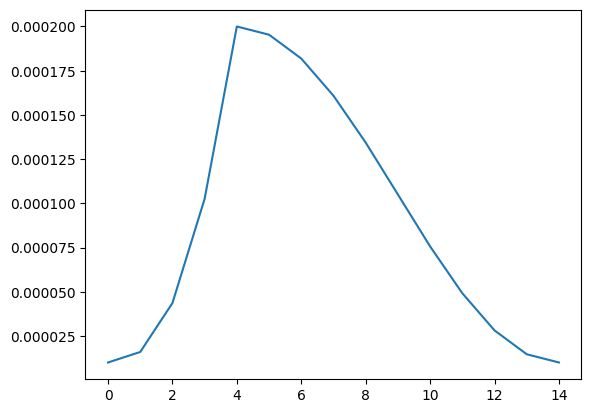

In [4]:
def lr_tune(epoch, num_epochs=NUM_EPOCHS):
    lr_start = LR_START
    lr_max = LR_MAX
    lr_final = LR_FINAL
    lr_warmup_epoch = 4
    lr_sustain_epoch = 0
    lr_decay_epoch = num_epochs - lr_warmup_epoch - lr_sustain_epoch - 1

    if epoch <= lr_warmup_epoch:
        lr = lr_start + (lr_max - lr_start) * (epoch / lr_warmup_epoch) ** 2.5
    elif epoch < lr_warmup_epoch + lr_sustain_epoch:
        lr = lr_max
    else:
        epoch_diff = epoch - lr_warmup_epoch - lr_sustain_epoch
        decay_factor = (epoch_diff / lr_decay_epoch) * math.pi
        decay_factor = (torch.cos(torch.tensor(decay_factor)).numpy() + 1) / 2
        lr = lr_final + (lr_max - lr_final) * decay_factor
    return lr
x = [i for i in range(NUM_EPOCHS)]
y = [lr_tune(i) for i in x]
plt.plot(x, y)

# tr3.albumentations

In [5]:
train_augs = A.Compose(
    [
        A.RandomResizedCrop(IMAGE_SIZE, IMAGE_SIZE),
        A.Transpose(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        A.CoarseDropout(p=0.5),
        A.Cutout(p=0.5),
        ToTensorV2(p=1.0)
    ], p=1.0)
valid_augs = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.CenterCrop(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(
             mean=[0.485, 0.456, 0.406],
             std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2(),
    ]
)

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


# tr4.TTA

In [6]:
test_augs = A.Compose([
    A.OneOf([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE, p=1.0),
        A.CenterCrop(IMAGE_SIZE, IMAGE_SIZE, p=1.0),
        A.RandomResizedCrop(IMAGE_SIZE, IMAGE_SIZE, p=1.0)
    ], p=1.0),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
    ToTensorV2(p=1.0)
    ], p=1.0
)

# tr5.seed

In [7]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
seed_everything(SEED)

# 定义数据集

In [8]:
class MyCassavaLeafDataset(Dataset):
    @staticmethod
    def generate_index(num_total, ratio):
        if ratio != 0.0:
            all_index = [i for i in range(num_total)]
            k = ratio * 10
            valid_index = np.arange(0, num_total, k)
            train_index = [i for i in all_index if i not in valid_index]
            return train_index, valid_index
        else:
            return [i for i in range(num_total)], []

    def __init__(self, csv_path=None, images_path=None, transform=None, mode='train', train_ratio=0.5):
        super().__init__()
        self.transform = transform
        self.mode = mode
        self.images_path = images_path
        self.data_info = pd.read_csv(csv_path)
        self.data_len = self.data_info.shape[0]
        if self.mode == 'train':
            train_index, _ = MyCassavaLeafDataset.generate_index(self.data_len, train_ratio)
            self.image_arr = np.asarray(self.data_info.iloc[train_index, 0])
            self.label_arr = np.asarray(self.data_info.iloc[train_index, 1])
            self.real_len = len(self.image_arr)
        elif self.mode == 'valid':
            _, valid_index = MyCassavaLeafDataset.generate_index(self.data_len, train_ratio)
            self.image_arr = np.asarray(self.data_info.iloc[valid_index, 0])
            self.label_arr = np.asarray(self.data_info.iloc[valid_index, 1])
            self.real_len = len(self.image_arr)

    def __getitem__(self, index):
        if self.mode != 'test':
            single_image_name = self.image_arr[index]
            image = Image.open(os.path.join(self.images_path, single_image_name))
            image = np.array(image)
            label = self.label_arr[index]
            return self.transform(image=image)["image"], label


    def __len__(self):
        return self.real_len

In [9]:
train_set = MyCassavaLeafDataset(csv_path=TRAIN_CSV_PATH, images_path=TRAIN_IMAGE_PATH, transform=train_augs, mode='train', train_ratio=0.0)
my_train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_set = MyCassavaLeafDataset(csv_path=TRAIN_CSV_PATH, images_path=TRAIN_IMAGE_PATH, transform=valid_augs, mode='valid')
my_valid_dataloader = torch.utils.data.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)

# 定义模型

In [10]:
model_name = "resnext50_32x4d"  # ns 表示 noisy student
my_model = timm.create_model(model_name, pretrained=True)
my_model.fc = nn.Linear(my_model.fc.in_features, OUT_FEATURES)
nn.init.xavier_uniform_(my_model.fc.weight)
if my_model.fc.bias is not None:
    nn.init.zeros_(my_model.fc.bias)
my_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_

# 定义训练

In [11]:
class MyTrainer:
    @staticmethod
    def accurate_count(y_hat, y_true):
        y_hat = y_hat.argmax(axis=1)
        y_true = y_true.argmax(axis=1)
        correct_count = 0
        for i in range(len(y_hat)):
            if y_hat[i].type(y_true.dtype) == y_true[i]:
                correct_count += 1
        return float(correct_count)
    @staticmethod
    def calc_valid_acc(model, valid_dataloader):
        model.eval()
        device = next(iter(model.parameters())).device
        test_num = 0
        test_acc_num = 0
        for x, y_true in valid_dataloader:
            if isinstance(x, list):
                x = [x_1.to(device) for x_1 in x]
            else:
                x = x.to(device)
            y_true_tensor = torch.zeros(size=(len(y_true), OUT_FEATURES))
            for i in range(len(y_true)):
                label = y_true[i]
                y_true_tensor[i, label] = 1
            y_true = y_true_tensor
            y_true = y_true.to(device)
            test_num += y_true.shape[0]
            test_acc_num += MyTrainer.accurate_count(model(x), y_true)
        return test_acc_num / test_num

    def __init__(self, optimizer, model, criterion, train_dataloader, valid_dataloader, param_group=True, learning_rate=lr_tune, num_epochs=NUM_EPOCHS, devices=DEVICES):
        self.optimizer_class = optimizer
        self.model = model
        self.criterion = criterion
        self.devices = devices
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.param_group = param_group
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
    def train_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        train_num = 0
        train_acc_num = 0
        batch_num = len(self.train_dataloader)
        param_1x = [param for name, param in self.model.named_parameters() if
                    name not in ['module.fc.weight', 'module.fc.bias']]
        optimizer = self.optimizer_class([{'params': param_1x},
                            {'params': self.model.module.fc.parameters(),
                            'lr': self.learning_rate(epoch) * 10}],
                            lr=self.learning_rate(epoch), weight_decay=0.001)
        print(f'epoch{epoch + 1} begins:')
        tk0 = tqdm(enumerate(self.train_dataloader), total=batch_num)
        for batch_idx, (x, y_true) in tk0:
            y_true_tensor = torch.zeros(size=(len(y_true), OUT_FEATURES))
            for i in range(len(y_true)):
                label = y_true[i]
                y_true_tensor[i, label] = 1
            y_true = y_true_tensor
            x, y_true = x.to(self.devices[0]), y_true.to(self.devices[0])
            optimizer.zero_grad()
            y_hat = self.model(x)
            loss = self.criterion(y_hat, y_true)
            loss.sum().backward()
            optimizer.step()
            total_loss += loss.sum()
            train_num += y_true.shape[0]
            train_acc_num += MyTrainer.accurate_count(y_hat, y_true)

        return total_loss / train_num, train_acc_num / train_num
    def train(self):
        best_valid_acc = 0
        self.model = nn.DataParallel(self.model ,device_ids=self.devices).to(self.devices[0])
        for epoch in range(self.num_epochs):
            # for name, param in self.model.named_parameters()
            #     print(name)
            train_loss, train_acc = MyTrainer.train_epoch(self, epoch)
            # valid_acc = MyTrainer.calc_valid_acc(self.model, self.valid_dataloader)
            if epoch == self.num_epochs - 1:
                torch.save(self.model.state_dict(), os.path.join('res50ver0.pth'))
            print(f'epoch{epoch + 1}:train_loss:{train_loss}, train_acc:{train_acc}')

# 训练

In [12]:
torch.cuda.empty_cache()

In [13]:
my_criterion = F.binary_cross_entropy_with_logits
my_trainer = MyTrainer(OPTIMIZER, my_model, my_criterion, my_train_dataloader, my_valid_dataloader)
my_trainer.train()

epoch1 begins:


100%|██████████| 669/669 [21:26<00:00,  1.92s/it]


epoch1:train_loss:0.11863663047552109, train_acc:0.6408375005841941
epoch2 begins:


100%|██████████| 669/669 [19:42<00:00,  1.77s/it]


epoch2:train_loss:0.09701864421367645, train_acc:0.7210823947282329
epoch3 begins:


100%|██████████| 669/669 [19:45<00:00,  1.77s/it]


epoch3:train_loss:0.08489444851875305, train_acc:0.77309903257466
epoch4 begins:


100%|██████████| 669/669 [19:48<00:00,  1.78s/it]


epoch4:train_loss:0.07585834711790085, train_acc:0.8140860868346029
epoch5 begins:


100%|██████████| 669/669 [19:47<00:00,  1.77s/it]


epoch5:train_loss:0.07132335752248764, train_acc:0.8307239332616722
epoch6 begins:


100%|██████████| 669/669 [19:44<00:00,  1.77s/it]


epoch6:train_loss:0.06623145937919617, train_acc:0.8446978548394635
epoch7 begins:


100%|██████████| 669/669 [19:55<00:00,  1.79s/it]


epoch7:train_loss:0.06357015669345856, train_acc:0.8501191755853624
epoch8 begins:


100%|██████████| 669/669 [19:48<00:00,  1.78s/it]


epoch8:train_loss:0.060716547071933746, train_acc:0.8601205776510725
epoch9 begins:


100%|██████████| 669/669 [19:52<00:00,  1.78s/it]


epoch9:train_loss:0.058541439473629, train_acc:0.8648876010655699
epoch10 begins:


100%|██████████| 669/669 [19:57<00:00,  1.79s/it]


epoch10:train_loss:0.057026591151952744, train_acc:0.8706360704771697
epoch11 begins:


100%|██████████| 669/669 [20:00<00:00,  1.80s/it]


epoch11:train_loss:0.05439676716923714, train_acc:0.8748422676076085
epoch12 begins:


100%|██████████| 669/669 [20:00<00:00,  1.79s/it]


epoch12:train_loss:0.05264975130558014, train_acc:0.8789549936907043
epoch13 begins:


100%|██████████| 669/669 [20:06<00:00,  1.80s/it]


epoch13:train_loss:0.0509910024702549, train_acc:0.8835350750105155
epoch14 begins:


100%|██████████| 669/669 [20:01<00:00,  1.80s/it]


epoch14:train_loss:0.050558675080537796, train_acc:0.8818058606346684
epoch15 begins:


100%|██████████| 669/669 [20:01<00:00,  1.80s/it]


epoch15:train_loss:0.050302643328905106, train_acc:0.8819928027293545
